In [1]:
import warnings   #
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange
import random
#import xgboost as xgb
#from xgboost import XGBRegressor

%matplotlib inline

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

In [4]:
def scatter_loss_plot():
    plt.subplot(1,2,1)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_test[colnames[0]],y_test_pred[0],'.')

    
    plt.subplot(1,2,2)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_train[colnames[0]],y_train_pred[0],'.')

    
def rmse(obs,pre):
    return np.sqrt(mean_squared_error(obs, pre))
    
def caculate_cor():
    global r_test,r_train,y_test_pred,y_train_pred,rmse_test,rmse_train
    y_test_pred=pd.DataFrame(model.predict(x_test).reshape(y_test.shape),index=test_index)
    r_test=np.corrcoef(y_test_pred[0],y_test[colnames[0]])
    y_train_pred=pd.DataFrame(model.predict(x_train).reshape(y_train.shape),index=train_index)
    r_train=np.corrcoef(y_train_pred[0],y_train[colnames[0]])
    rmse_test=rmse(y_test[colnames[0]],y_test_pred[0])
    rmse_train=rmse(y_train[colnames[0]],y_train_pred[0])

# rf-regression

In [4]:
import joblib
#xl = pd.ExcelFile('RF20210202.xlsx')
#predf=pd.read_excel('experiment materials.xlsx',sheet_name=1).iloc[0:5,0:31]

writer1=pd.ExcelWriter('11.18-RF-op.xlsx')
writer2=pd.ExcelWriter('11.18-RF-cor.xlsx')
writer3=pd.ExcelWriter('11.18-RF-imp.xlsx')
writer4=pd.ExcelWriter('11.18-RF-pre.xlsx')
writer5=pd.ExcelWriter('11.18-RF-val.xlsx')

In [ ]:
for i in trange(0,2):
    frame=pd.read_excel(r'D:\策划类\01NKU\机器学习中的因果推断\因果机器学习\14第十四次组会文献\11.18-Ocean数据更新\11-18-Ocean-data.xlsx',sheet_name=i)
    #frame=pd.read_excel(r'C:\Users\dell\Desktop\Ocean-code-R\10.19-Ocean-data.xlsx',sheet_name=i)
    
    random.seed(3)
    
    val=random.sample(range(0,len(frame)),5)           #随机抽取所有数据中的5个样本
    model_index=list(frame.index)

    for j in val:
        model_index.remove(j)
    valdata=frame.loc[val,:]
    val_x=valdata.iloc[:,0:20]
    val_y=valdata.iloc[:,20:]
    frame=frame.loc[model_index,:]
    x_data=frame.iloc[:,0:20]
    #x_data=frame[globals()['colindex'+str(i)]]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,20:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    
    #stdsc=StandardScaler()
    prelist=[]
    vallist=[]
    corlist_train=[]
    corlist_test=[]
    rmsel_train=[]
    rmsel_test=[]
    o=[]
    imp=[]
    

    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=6)  #,min_samples_leaf=2)
    #model=LGBMRegressor(learning_rate=0.5, max_depth=9,random_state=0)
    #model=XGBRegressor(random_state=0)
    
    #with tqdm(total=10) as pbar:
    for train_index , test_index in ss.split(x_data,y_data):
        x_train=x_data.iloc[train_index,:]
        x_train.columns=x_names
        
        y_train=y_data.iloc[train_index,:]
        
        x_test=x_data.iloc[test_index,:]
        x_test.columns=x_names
    
        y_test=y_data.iloc[test_index,:]
        
        model.fit(x_train,np.array(y_train).ravel())       #模型拟合
        
        
        joblib.dump(model, f'11.18-{i}.pkl')
        
        val_one=model.predict(val_x)
        
        vallist.append(val_one.T)
        #pre_one=model.predict(predf)
        #prelist.append(pre_one.T)
        caculate_cor()
        corlist_train.append(r_train[1,0])
        corlist_test.append(r_test[1,0])
        rmsel_train.append(rmse_train)
        rmsel_test.append(rmse_test)
       # scatter_loss_plot()
        o.append(y_train[colnames[0]])
        o.append(y_train_pred[0])
        o.append(y_test[colnames[0]])
        o.append(y_test_pred[0])
        #pbar.update()           
        imp.append(model.feature_importances_)

    #plt.show()        
    cordf=pd.DataFrame({'train':corlist_train,'test':corlist_test,
                        'rmse_train':rmsel_train,'rmse_test':rmsel_test})
    obs_pre_df=pd.DataFrame([y_data[colnames[0]],o[1],o[5],o[9],o[13],o[17],o[21],o[25],o[29],o[33],o[37],
                            o[3],o[7],o[11],o[15],o[19],o[23],o[27],o[31],o[35],o[39]]).T
    obs_pre_df.columns=(colnames[0],'train1','train2','train3','train4','train5',
                        'train6','train7','train8','train9','train10',
                        'test1','test2','test3','test4','test5',
                        'test6','test7','test8','test9','test10')
    #可能是numpy问题，注释掉了
    presult=pd.DataFrame(prelist,columns=['T','C','S','M','L']).T
    vresult=pd.DataFrame(vallist,columns=val).T
    
    print(np.corrcoef(np.array(np.mean(vresult.T)).ravel(),np.array(val_y).ravel())[0,1])
    
    vresult['predict']=np.array(np.mean(vresult.T)).ravel()
    vresult['observe']=val_y
    vresult['error']=vresult['predict']-vresult['observe']

    imp_df=pd.DataFrame(imp,columns=globals()['colindex'+str(i)])
    imp_df=pd.DataFrame(imp,columns=x_names)
    obs_pre_df.to_excel(writer1,sheet_name=colnames[0])
    cordf.to_excel(writer2,sheet_name=colnames[0])
    imp_df.to_excel(writer3,sheet_name=colnames[0])
    presult.to_excel(writer4,sheet_name=colnames[0])
    vresult.to_excel(writer5,sheet_name=colnames[0])
    
writer1.save()
writer2.save()
writer3.save()
writer4.save()
writer5.save()

# 新版本

In [12]:
import joblib
writer1=pd.ExcelWriter('G:\\Ocean-final5\\0-Model performance\\All-RF-op.xlsx')
writer2=pd.ExcelWriter('G:\\Ocean-final5\\0-Model performance\\All-RF-cor.xlsx')

for i in trange(0,2):
    #frame=pd.read_excel(r'G:\Ocean-final\12-10-Ocean-data.xlsx',sheet_name=i)
    frame=pd.read_excel(r'G:\Ocean-final2\12-10-Ocean-data.xlsx',sheet_name=i)
    
    random.seed(3)
    
    val=random.sample(range(0,len(frame)),5)           #随机抽取所有数据中的5个样本
    model_index=list(frame.index)

    for j in val:
        model_index.remove(j)
    valdata=frame.loc[val,:]
    val_x=valdata.iloc[:,0:20]
    val_y=valdata.iloc[:,20:]
    frame=frame.loc[model_index,:]
    x_data=frame.iloc[:,0:20]
    #x_data=frame[globals()['colindex'+str(i)]]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,20:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    
    #stdsc=StandardScaler()
    prelist=[]
    vallist=[]
    corlist_train=[]
    corlist_test=[]
    rmsel_train=[]
    rmsel_test=[]
    o=[]
    imp=[]
    
    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=6)  #,min_samples_leaf=2)
    #model=XGBRegressor(random_state=0,n_jobs=1)
    #model=LGBMRegressor(learning_rate=0.5, max_depth=9,random_state=0)
 
    #with tqdm(total=10) as pbar:
    for train_index , test_index in ss.split(x_data,y_data):
        x_train=x_data.iloc[train_index,:]
        x_train.columns=x_names
        
        y_train=y_data.iloc[train_index,:]
        
        x_test=x_data.iloc[test_index,:]
        x_test.columns=x_names
    
        y_test=y_data.iloc[test_index,:]
        
        model.fit(x_train,np.array(y_train).ravel())       #模型拟合
        
        
        #joblib.dump(model, f'XGB-Ocean-{i}.pkl')
        
        val_one=model.predict(val_x)
        
        vallist.append(val_one.T)
        #pre_one=model.predict(predf)
        #prelist.append(pre_one.T)
        caculate_cor()
        corlist_train.append(r_train[1,0])
        corlist_test.append(r_test[1,0])
        rmsel_train.append(rmse_train)
        rmsel_test.append(rmse_test)
       # scatter_loss_plot()
        o.append(y_train[colnames[0]])
        o.append(y_train_pred[0])
        o.append(y_test[colnames[0]])
        o.append(y_test_pred[0])
        #pbar.update()           
        imp.append(model.feature_importances_)

    #plt.show()        
    cordf=pd.DataFrame({'train':corlist_train,'test':corlist_test,
                        'rmse_train':rmsel_train,'rmse_test':rmsel_test})
    obs_pre_df=pd.DataFrame([y_data[colnames[0]],o[1],o[5],o[9],o[13],o[17],o[21],o[25],o[29],o[33],o[37],
                            o[3],o[7],o[11],o[15],o[19],o[23],o[27],o[31],o[35],o[39]]).T
    obs_pre_df.columns=(colnames[0],'train1','train2','train3','train4','train5',
                        'train6','train7','train8','train9','train10',
                        'test1','test2','test3','test4','test5',
                        'test6','test7','test8','test9','test10')
    obs_pre_df.to_excel(writer1,sheet_name=colnames[0])
    cordf.to_excel(writer2,sheet_name=colnames[0])
    
writer1.close()
writer2.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:26<00:00, 43.10s/it]


# 网格调参

In [ ]:
import joblib
from sklearn.model_selection import GridSearchCV

writer1 = pd.ExcelWriter('G:\\Ocean-final5\\0-Model performance\\网格搜索调参\\All-RF-op.xlsx')
writer2 = pd.ExcelWriter('G:\\Ocean-final5\\0-Model performance\\网格搜索调参\\All-RF-cor.xlsx')

for i in trange(0, 1):
    frame = pd.read_excel(r'G:\Ocean-final2\12-10-Ocean-data.xlsx', sheet_name=i)

    random.seed(3)

    val = random.sample(range(0, len(frame)), 5)
    model_index = list(frame.index)

    for j in val:
        model_index.remove(j)
    valdata = frame.loc[val, :]
    val_x = valdata.iloc[:, 0:20]
    val_y = valdata.iloc[:, 20:]
    frame = frame.loc[model_index, :]
    x_data = frame.iloc[:, 0:20]
    x_data.index = range(len(x_data))
    y_data = frame.iloc[:, 20:]
    y_data.index = range(len(y_data))
    x_names = x_data.columns.values.tolist()
    colnames = y_data.columns.values.tolist()

    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

    prelist = []
    vallist = []
    corlist_train = []
    corlist_test = []
    rmsel_train = []
    rmsel_test = []
    o = []
    imp = []

    # Define parameter grid for grid search
    param_grid = {
        'learning_rate': [0.1, 0.01, 0.5],
        'max_depth': [4, 6, 8]}

    #model = RandomForestRegressor(oob_score=True, random_state=0)
    model = LGBMRegressor(random_state=0)

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=ss)

    for train_index, test_index in ss.split(x_data, y_data):
        x_train = x_data.iloc[train_index, :]
        x_train.columns = x_names

        y_train = y_data.iloc[train_index, :]

        x_test = x_data.iloc[test_index, :]
        x_test.columns = x_names

        y_test = y_data.iloc[test_index, :]

        # Fit the model with grid search
        grid_search.fit(x_train, np.array(y_train).ravel())

        best_model = grid_search.best_estimator_

        # Output best parameters
        print("Best parameters found: ", grid_search.best_params_)

        # Predict using the best model
        val_one = best_model.predict(val_x)
        vallist.append(val_one.T)

        caculate_cor()
        corlist_train.append(r_train[1, 0])
        corlist_test.append(r_test[1, 0])
        rmsel_train.append(rmse_train)
        rmsel_test.append(rmse_test)
        o.append(y_train[colnames[0]])
        o.append(y_train_pred[0])
        o.append(y_test[colnames[0]])
        o.append(y_test_pred[0])
        imp.append(best_model.feature_importances_)

    cordf = pd.DataFrame({'train': corlist_train, 'test': corlist_test,
                          'rmse_train': rmsel_train, 'rmse_test': rmsel_test})
    obs_pre_df = pd.DataFrame([y_data[colnames[0]], o[1], o[5], o[9], o[13], o[17], o[21], o[25], o[29], o[33], o[37],
                               o[3], o[7], o[11], o[15], o[19], o[23], o[27], o[31], o[35], o[39]]).T
    obs_pre_df.columns = (colnames[0], 'train1', 'train2', 'train3', 'train4', 'train5',
                          'train6', 'train7', 'train8', 'train9', 'train10',
                          'test1', 'test2', 'test3', 'test4', 'test5',
                          'test6', 'test7', 'test8', 'test9', 'test10')
    obs_pre_df.to_excel(writer1, sheet_name=colnames[0])
    cordf.to_excel(writer2, sheet_name=colnames[0])

writer1.close()
writer2.close()


# permutation test

In [5]:
#xl = pd.ExcelFile(r'C:\Users\dell\code\常用工具（处理数据）\Ocean-data-log-异常值处理.xlsx')
xl = pd.ExcelFile(r'G:\Ocean-final2\12-10-Ocean-data.xlsx')

namelist=xl.sheet_names[0:2]
model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                                max_features=6)
writer1=pd.ExcelWriter('G:\\Ocean-final5\\Ocean-permutation test.xlsx')

In [6]:
for i in trange(0,2):
    #frame=pd.read_excel(r'C:\Users\dell\code\常用工具（处理数据）\Ocean-data-log-异常值处理.xlsx',sheet_name=i)
    #frame=pd.read_excel(r'C:\Users\dell\Desktop\2023-12-24-Ocean-重新建模流程\11-18-Ocean-data.xlsx',sheet_name=i)
    frame=pd.read_excel(r'G:\Ocean-final2\12-10-Ocean-data.xlsx',sheet_name=i)
    
    random.seed(i)
    val=random.sample(range(0,len(frame)),5)
    model_index=list(frame.index)
    for j in val:
        model_index.remove(j)
    #x_data=frame[globals()['colindex'+str(i)]]
    valdata=frame.iloc[val,:]
    val_x=valdata.iloc[:,0:20]
    val_y=valdata.iloc[:,20:]
    frame=frame.iloc[model_index,:]
    x_data=frame.iloc[:,0:20]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,20:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    #stdsc=StandardScaler()
    r2_list=[]
    q2_list=[]
    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                                max_features=6)
    with tqdm(total=10) as pbar:
        for train_index , test_index in ss.split(x_data,y_data):
            x_train=x_data.iloc[train_index,:]
            x_train.columns=x_names
            y_train=y_data.iloc[train_index,:]
            x_test=x_data.loc[test_index,:]
            x_test.columns=x_names        
            y_test=y_data.loc[test_index,:]
            
            for j in trange(5):
                for k in range(10):
                    random.seed(i+j+k)
                    per_index=np.random.choice(train_index,round((j+1)*0.2*len(x_train)),False)
                    y_train_per=y_train.copy()
                    for i_index in per_index:
                        y_train_per.loc[i_index,:]=np.random.uniform(-1,1)
                    model.fit(x_train,np.array(y_train_per).ravel())
                    r2_list.append(
                        np.corrcoef(y_train.iloc[:,0],y_train_per.iloc[:,0])[0,1])
                    y_array=np.array(y_test).ravel()
                    rss=np.sum((y_array-model.predict(x_test))**2)                          
                    tss=np.sum((y_array-np.mean(y_array))**2)
                    q2=1-rss/tss
                    q2_list.append(q2)
                
            model.fit(x_train,np.array(y_train).ravel())
            r2_list.append(1)
            rss=np.sum((y_array-model.predict(x_test))**2)                          
            tss=np.sum((y_array-np.mean(y_array))**2)
            q2=1-rss/tss
            q2_list.append(q2)
            pbar.update() 
             
    perdf=pd.DataFrame({'r2':r2_list,'q2':q2_list})
    
    #plt.ylim(-2,1)
    #plt.xlim(0,1)
    #plt.plot(perdf['r2'],perdf['q2'],'.')
    #plt.show()
    perdf.to_excel(writer1,sheet_name=colnames[0])
writer1.close()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [01:01<04:07, 61.79s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [02:02<03:03, 61.19s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:59<01:58, 59.44s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:54<00:57, 57.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:48<00:00, 57.60s/it]

 10%|████████▏                                                                         | 1/10 [04:50<43:34, 290.55s/it]

  0%|                           

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:32<00:00, 54.43s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [37:18<09:19, 279.93s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:55<03:42, 55.54s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [01:51<02:47, 55.78s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:46<01:50, 55.49s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:43<00:55, 55.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:36<00:00, 55.25s/it]

 90%|███████████████████████████

In [9]:
df = pd.read_excel(r'G:\Ocean-final5\0-Model performance\All-RF-op.xlsx',sheet_name=0)

In [10]:
true_value = pd.Series(df.iloc[:, 1])   #读取数据的真实值
train = df.iloc[:, 2:12].mean(axis=1)
test = df.iloc[:, 12:22].mean(axis=1)
test_missing_indices = test.index[test.isna()]  # 记录测试集中的缺失值索引
test.dropna(inplace=True)
true_value_missing_indices = true_value.index.intersection(test_missing_indices)  # 找到与测试集中缺失值对应的真实值的索引
true_value.drop(index=true_value_missing_indices, inplace=True)
true_value2 = pd.Series(df.iloc[:, 1])   #读取数据的真实值，用来赋给train

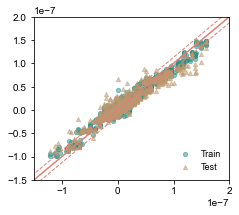

In [11]:
plt.rcParams['font.sans-serif'] = ['Arial']

# 绘制真实值和预测值的散点图
plt.figure(figsize=(3.5, 3))

# 设置坐标轴范围
plt.axis([-1.5E-07,2.0E-07, -1.5E-07,2.0E-07])   #-1.5E-07，1.7E-07
#plt.axis([-0.05, 4, -0.05, 4])

# 绘制训练集和测试集的散点图
plt.scatter(true_value2, train, color='#249087',marker='o',s=18, label='Train',alpha=0.5)
plt.scatter(true_value, test, color='#BB996F',marker='^',s=18,label='Test',alpha=0.5)


#plt.scatter(true_value2, train, color='#fba502',marker='^',s=40, label='Train',alpha=1)
#1plt.scatter(true_value, test, color='#00bfbe',marker='o',s=40,label='Test',alpha=0.5)


x = np.linspace(-0.05,4, 100)

# 绘制 y=x 的对角线
slope = 1
intercept = 0
y = slope * x+ intercept
plt.plot(x, y,color='#e08075',linestyle='-', linewidth=1.5)   ##00bfbe

# 计算测试集预测结果均值和标准差
rmse_test = np.sqrt(mean_squared_error(true_value, test))
#mean_test = np.mean(true_values)

#加入约束线，截距为标准差加减
intercept2 = rmse_test
y2 = slope * x + intercept2
y3 = slope * x - intercept2
plt.plot(x, y2, color='#e08075', linestyle='--', linewidth=1)
plt.plot(x, y3, color='#e08075', linestyle='--', linewidth=1)

##008B8B

# 设置横纵坐标轴标签和图例
#plt.xticks(np.arange(-1.5E-07, 2.1E-07, 0.9E-07))
#plt.yticks(np.arange(-1.5E-07, 2.1E-07, 0.9E-07))
plt.rcParams['pdf.fonttype'] = 42
plt.legend(loc='lower right',frameon=False,prop={'size': 9})
plt.savefig("G:\\Ocean-final5\\0-Model performance\\co2.pdf", dpi=600)
plt.show()

# 拟合

In [7]:
import pandas as pd
import joblib
import numpy as np
import shap

# 创建Excel Writer对象
writer1 = pd.ExcelWriter('Ocean-feature_importance-Diversity.xlsx')
writer2 = pd.ExcelWriter('Ocean-shap-value-Diversity.xlsx')

# 读取名称
#raw_data = pd.ExcelFile(r'C:\Users\dell\Desktop\Ocean-code-R\10.19-Ocean-data.xlsx')
#raw_data = pd.ExcelFile(r'D:\策划类\01NKU\机器学习中的因果推断\因果机器学习\14第十四次组会文献\11.18-Ocean数据更新\11-18-Ocean-data.xlsx')
raw_data = pd.ExcelFile(r'G:\Ocean-final2\12-10-Ocean-data.xlsx')
sheet_names = list(raw_data.sheet_names)

# 循环处理每个模型和对应的Excel表格
# 读取模型

#model = joblib.load(f'G:\\Ocean-final2\\0-Model performance\\RF\\Ocean-0.pkl')
model = joblib.load(f'G:\\Ocean-final2\\0-Model performance\\RF\\Ocean-1.pkl')


i=1  #修改读取数据的列表
#df = pd.read_excel(r'C:\Users\dell\Desktop\Ocean-code-R\10.19-Ocean-data.xlsx', sheet_name=i)
df = pd.read_excel(r'G:\Ocean-final2\12-10-Ocean-data.xlsx',sheet_name=i)

    # 提取X和y
y = df.iloc[:, -1]
X = df.iloc[:, :-1]

    # 计算SHAP值
explainer = shap.TreeExplainer(model, feature_names=X.columns)
shap_values = explainer.shap_values(X)
    
    # 计算SHAP值的绝对值+均值
abs_shap_values = np.abs(shap_values)
feature_importance = np.mean(abs_shap_values, axis=0)
    
    # 创建DataFrame存储特征和均值
df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})  #特征重要性shap
shap_df = pd.DataFrame(shap_values, columns=X.columns)                       #单独shap值计算

    # 导出为Excel文件的不同sheet，sheet名称与原始数据的sheet名称一一对应
sheet_name = sheet_names[i]
df.to_excel(writer1, sheet_name=sheet_name, index=False)
shap_df.to_excel(writer2, sheet_name=sheet_name, index=False)

# 保存Excel文件
writer1.close()
writer2.close()